Model Performance Metrics:
               Accuracy  F1-Score   AUC-ROC
Random Forest  0.502008  0.403846  0.472060
SVM            0.562249  0.322981  0.479077
KNN            0.526104  0.438095  0.504094

ROC curve plot saved as 'roc_curve_comparison.png'


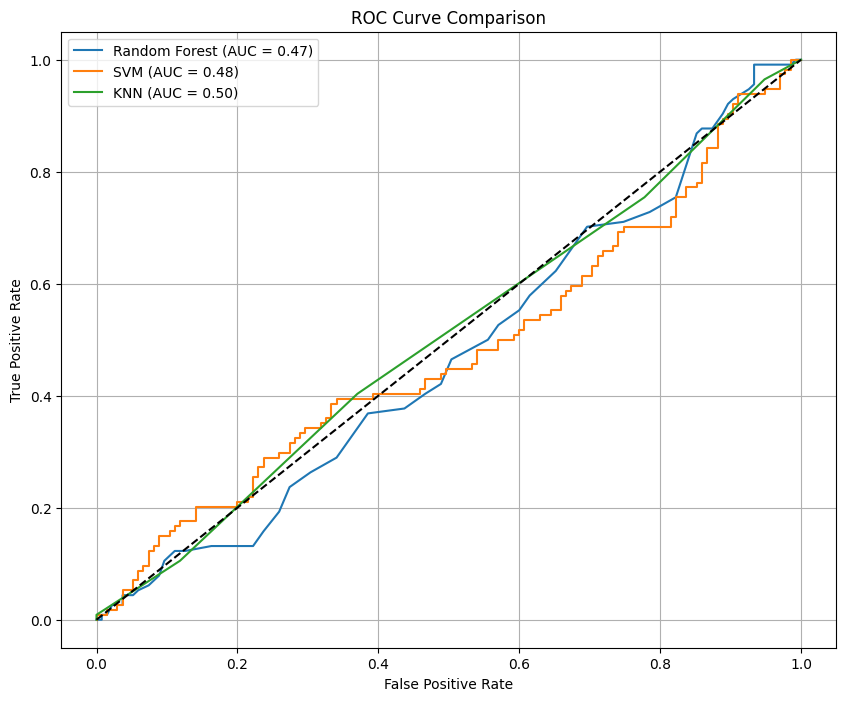

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the dataset
df = pd.read_csv('cleaned_stock_market_data.csv')

# --- Data Preprocessing ---

# Convert 'date' to datetime and extract features if needed, or drop if not directly useful
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

# Drop original date and other non-numeric columns for simplicity for now
df = df.drop(['date', 'month_name'], axis=1)

# Target variable engineering: predict if S&P 500 will go up or down
# 1 if returns are positive, 0 if negative or zero
df['target'] = (df['sp500_returns'] > 0).astype(int)

# Drop the original returns column
df = df.drop('sp500_returns', axis=1)

# Check for missing values
if df.isnull().sum().sum() > 0:
    # Simple imputation: fill with median
    df = df.fillna(df.median())

# Define features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Model Training and Evaluation ---

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        "Accuracy": accuracy,
        "F1-Score": f1,
        "AUC-ROC": auc
    }

# --- Results ---

results_df = pd.DataFrame(results).T
print("Model Performance Metrics:")
print(results_df)

# --- ROC Curve Visualization ---
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.savefig('roc_curve_comparison.png')
print("\nROC curve plot saved as 'roc_curve_comparison.png'")


Plot with all confusion matrices saved as 'all_confusion_matrices.png'


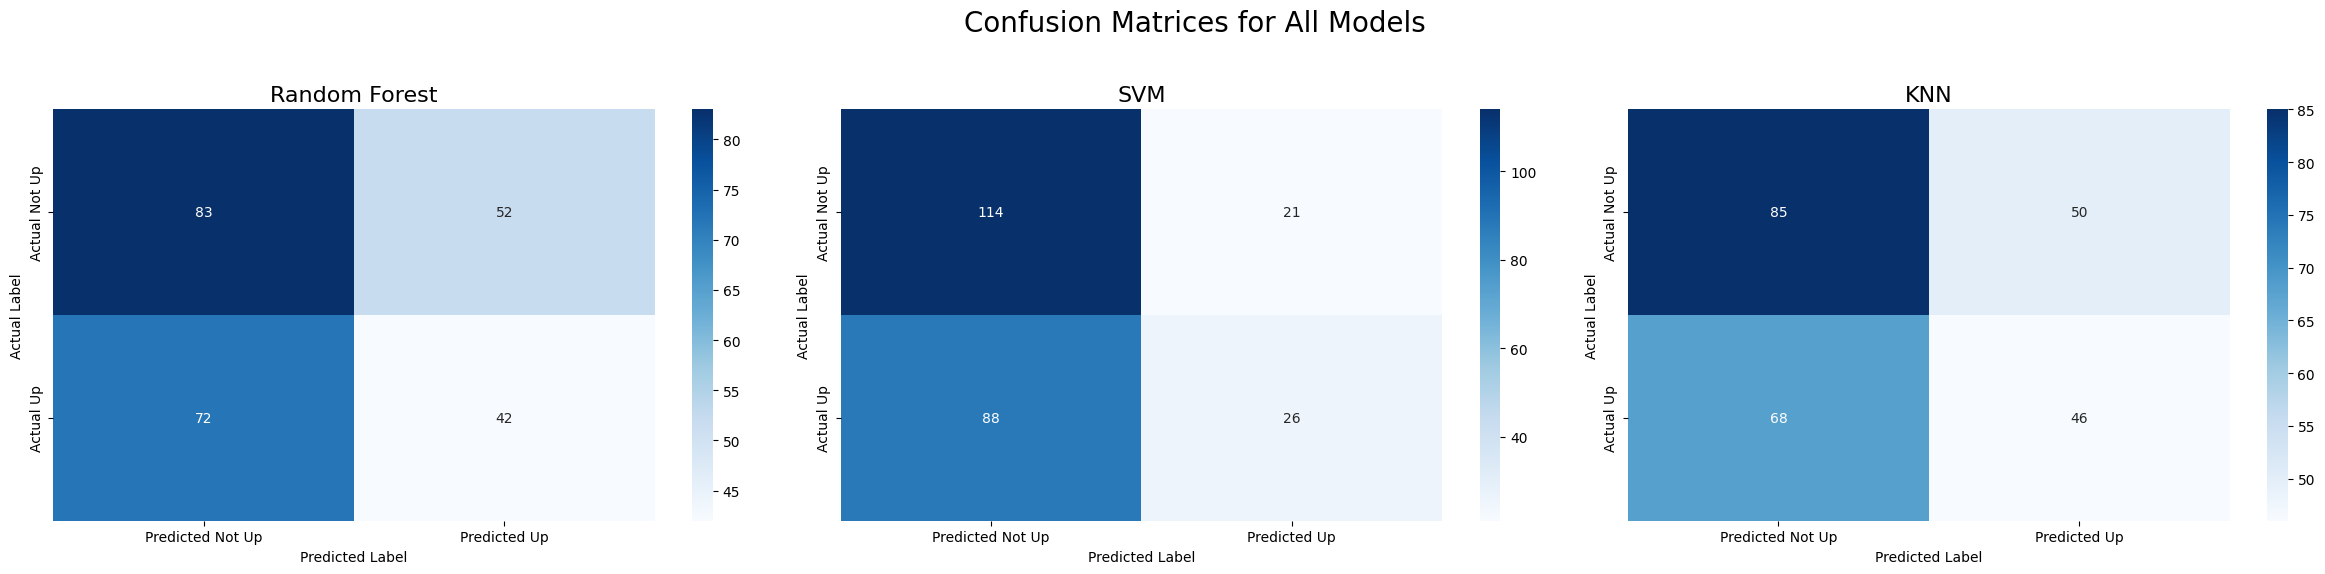

In [ ]:
# --- Generate and Print Confusion Matrices ---

# Create a figure to hold the subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
fig.suptitle('Confusion Matrices for All Models', fontsize=20)

for i, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scaled, y_train)
    # Get predictions
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    # 1. Visualize the matrix on a subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Predicted Not Up', 'Predicted Up'],
                yticklabels=['Actual Not Up', 'Actual Up'])
    axes[i].set_title(name, fontsize=16)
    axes[i].set_ylabel('Actual Label')
    axes[i].set_xlabel('Predicted Label')

# Adjust layout and save the combined figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('all_confusion_matrices.png')
print("\nPlot with all confusion matrices saved as 'all_confusion_matrices.png'")